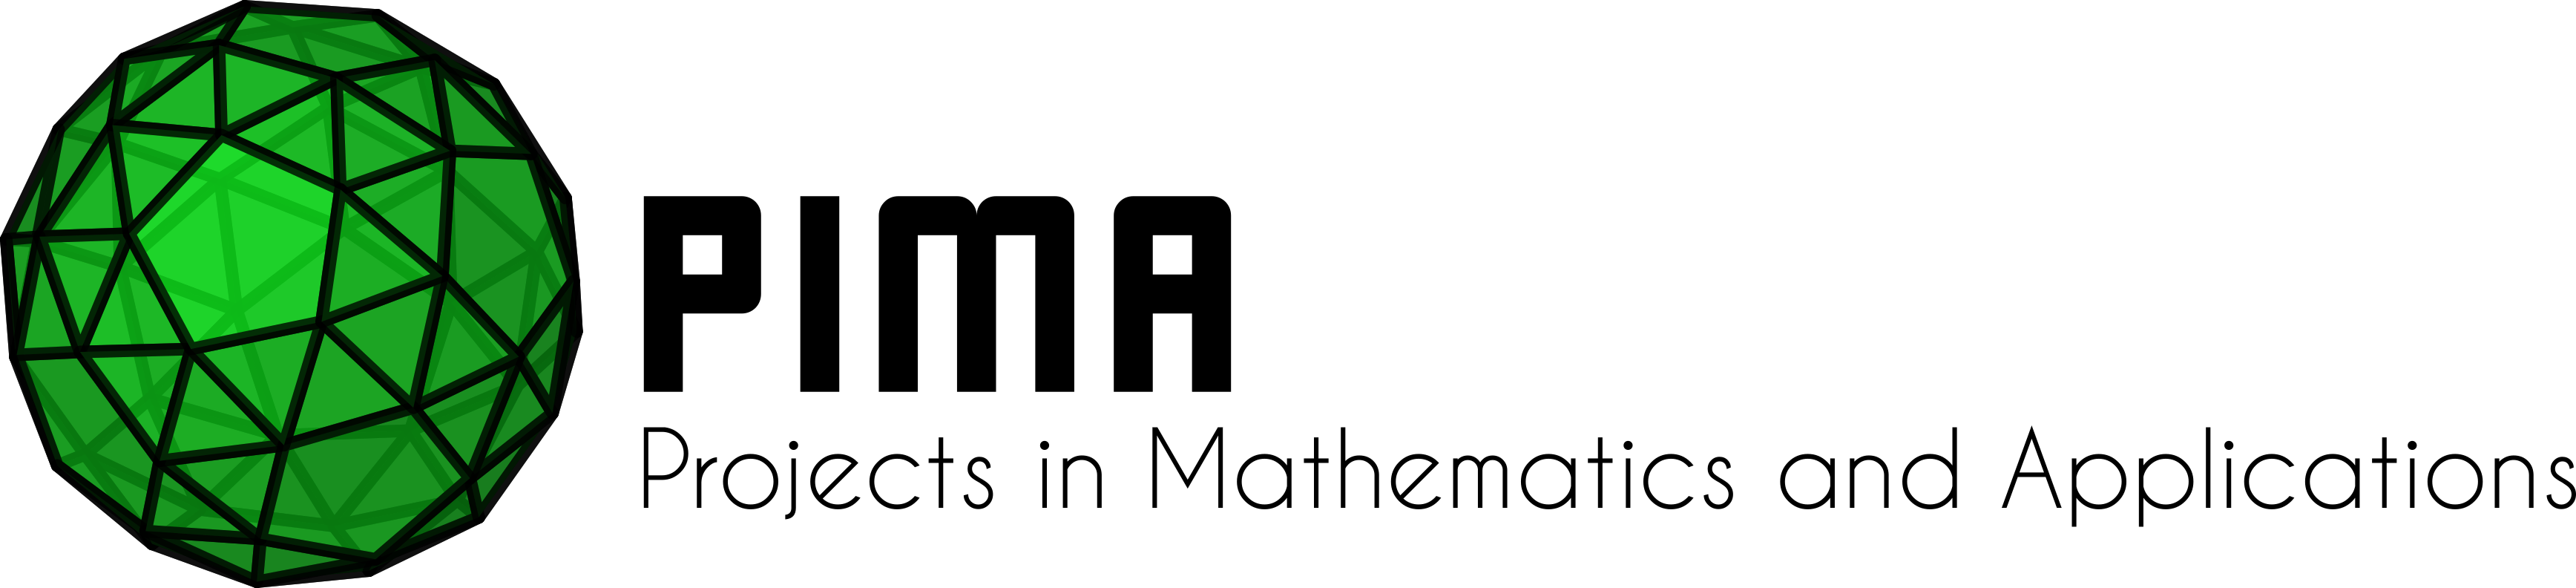

# Chuẩn bị trình chấm bài và thông tin học viên

In [1]:
import shutil
import subprocess
import sys

# Clean up old folders if they exist
shutil.rmtree("PiMA-GenAI-Grader", ignore_errors=True)
shutil.rmtree("grader_homework_7", ignore_errors=True)

# Clone the GitHub repo
subprocess.run(["git", "clone", "https://github.com/vongvinhtoan/PiMA-GenAI-Grader.git"], check=True)

# Move the folder
shutil.move("PiMA-GenAI-Grader/grader_homework_7", "./grader_homework_7")

# Install requirements
subprocess.check_call([sys.executable, "-m", "pip", "install", "-r", "./grader_homework_7/requirements.txt", "--quiet"])

print("")

In [2]:
student_id = int.from_bytes(b'PiMA-GenAI', byteorder='big') % 2**32

# Import các thư viện

In [3]:
import os
import numpy as np
import random
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch import Tensor
import torch.optim as optim

from torchvision import datasets, transforms
from torchvision.utils import make_grid , save_image

# Chuẩn bị nền tảng

In [4]:
torch.manual_seed(student_id)
np.random.seed(student_id)
random.seed(student_id)

In [5]:
def get_best_device():
    if torch.cuda.is_available():
        device = torch.device('cuda')
    elif torch.backends.mps.is_available():
        device = torch.device('mps')  # For Apple Silicon (Mac M1/M2)
    else:
        device = torch.device('cpu')
    return device

device = get_best_device()
print(f"Using device: {device}")

Using device: cuda


# Chuẩn bị dataset

In [6]:
# Chuẩn bị dataset (EMNIST split='letters')
train_dataset = datasets.EMNIST('./data',
    split='letters',
    download=True,
    train=True,
    transform=transforms.Compose(
        [transforms.ToTensor()]
    )
)
test_dataset = datasets.EMNIST('./data',
    split='letters',
    download=True,
    train=False,
    transform=transforms.Compose(
        [transforms.ToTensor()]
    )
)

100%|██████████| 562M/562M [00:05<00:00, 99.6MB/s]


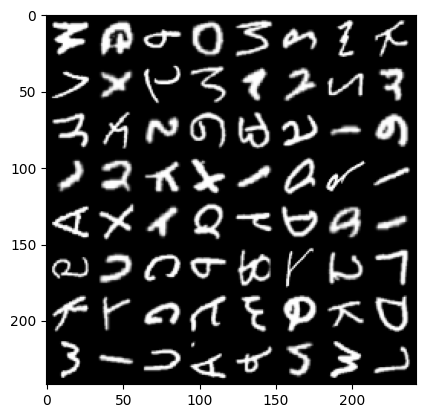

In [7]:
def show(img):
    npimg = np.transpose(img.numpy(), (1, 2, 0))
    plt.imshow(npimg, cmap='gray')

show(make_grid(train_dataset.data[:64].unsqueeze(1), nrow=8))

# Tự mã hóa biến phân (VAE)

In [8]:
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, dec_var, n_samples):
        super().__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim
        self.dec_var = dec_var
        self.n_samples = n_samples

        # Bộ mã hóa
        self.enc_share = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.Tanh(),
        )
        self.enc_mu = nn.Linear(hidden_dim, latent_dim)
        self.enc_log_var = nn.Linear(hidden_dim, latent_dim)

        # Bộ giải mã
        self.dec_mu = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid(),
        )

    def encoding(self, x: Tensor) -> tuple[Tensor, Tensor]:
        """
        Mã hóa đầu vào x thành vector kỳ vọng mu và log-variance (s^2).
        Đầu vào:
            x: Tensor [batch_size, input_dim]
        Đầu ra:
            Tuple (z_mu, z_log_var):
                - z_mu: Tensor [batch_size, latent_dim], vector kỳ vọng mu_phi(x)
                - z_log_var: Tensor [batch_size, latent_dim], vector s^2_phi(x)
        """
        h = self.enc_share(x)  # [batch_size, hidden_dim]
        z_mu = self.enc_mu(h)  # [batch_size, latent_dim]
        z_log_var = self.enc_log_var(h)  # [batch_size, latent_dim]
        return z_mu, z_log_var

    def decoding(self, z: Tensor) -> Tensor:
        """
        Giải mã biến ẩn z thành đầu ra tái tạo mu_theta(z).
        Đầu vào:
            z: Tensor [batch_size, latent_dim]
        Đầu ra:
            Tensor [batch_size, input_dim], giá trị mu_theta(z)
        """
        return self.dec_mu(z)  # [batch_size, input_dim]

    def calc_recon_loss(self, z_mu: Tensor, z_std: Tensor, x: Tensor) -> Tensor:
        """
        Tính mất mát tái tạo sử dụng Monte Carlo.
        Đầu vào:
            z_mu: Tensor [batch_size, latent_dim], vector kỳ vọng mu_phi(x)
            z_std: Tensor [batch_size, latent_dim], vector sigma_phi(x)
            x: Tensor [batch_size, input_dim], dữ liệu đầu vào
        Đầu ra:
            Tensor [batch_size], giá trị mất mát tái tạo cho mỗi mẫu
        """
        batch_size = x.size(0)
        recon_loss = torch.zeros(batch_size, device=x.device)

        for _ in range(self.n_samples):
            # Lấy mẫu epsilon ~ N(0, I)
            epsilon = torch.randn_like(z_std)  # [batch_size, latent_dim]
            # Tái tham số hóa: z = mu + std * epsilon
            z = z_mu + z_std * epsilon  # [batch_size, latent_dim]
            # Giải mã z thành x_hat
            x_hat = self.decoding(z)  # [batch_size, input_dim]
            # Tính MSE: ||x - x_hat||_2^2
            mse = F.mse_loss(x_hat, x, reduction='none').sum(dim=1)  # [batch_size]
            # Cộng vào mất mát tái tạo (chia 2*dec_var theo công thức)
            recon_loss += mse / (2 * self.dec_var)

        # Trung bình theo số mẫu Monte Carlo
        recon_loss /= self.n_samples
        return recon_loss

    def calc_kl_loss(self, z_log_var: Tensor, z_mu: Tensor, z_std: Tensor) -> Tensor:
        """
        Tính mất mát KL giữa q_i,phi và p_Z_i;theta.
        Đầu vào:
            z_log_var: Tensor [batch_size, latent_dim], vector s^2_phi(x)
            z_mu: Tensor [batch_size, latent_dim], vector mu_phi(x)
            z_std: Tensor [batch_size, latent_dim], vector sigma_phi(x)
        Đầu ra:
            Tensor [batch_size], giá trị mất mát KL cho mỗi mẫu
        """
        # Công thức KL: 1/2 * sum(-s^2 + exp(s^2) + mu^2 - 1)
        kl_loss = -0.5 * (z_log_var - torch.exp(z_log_var) - z_mu**2 + 1)
        # Tổng theo chiều latent_dim
        kl_loss = kl_loss.sum(dim=1)  # [batch_size]
        return kl_loss

    def get_loss(self, x: Tensor):
        # Mã hóa đầu vào
        z_mu, z_log_var = self.encoding(x)
        z_std = torch.exp(0.5 * z_log_var)

        # Tính loss tái tạo dựng
        recon_loss = self.calc_recon_loss(z_mu, z_std, x)

        # Tính loss KL
        kl_loss = self.calc_kl_loss(z_log_var, z_mu, z_std)

        # Tổng loss
        loss = recon_loss + kl_loss
        return loss.mean()

    @torch.no_grad()
    def sample(self, n_samples, to_device):
        random_z = torch.randn(n_samples, self.latent_dim, device=device)
        x_hat = self.decoding(random_z)
        return x_hat.to(to_device)

# Chuẩn bị thông số cho quá trình huấn luyện

In [13]:
batch_size = 128
input_dim = 28 * 28
hidden_dim = 500
latent_dim=20
n_epochs = 60
lr = 0.001
dec_var = 0.6
n_samples = 10

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

# Huấn luyện mô hình

In [14]:
model_vae = VAE(
    input_dim=input_dim,
    hidden_dim=hidden_dim,
    latent_dim=latent_dim,
    dec_var=dec_var,
    n_samples=n_samples
).to(device)

train_op = optim.Adam(model_vae.parameters(), lr)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(train_op, mode='min', factor=0.5, patience=5, verbose=True)
for epoch in tqdm(range(n_epochs)):
    # Train
    model_vae.train()
    train_loss = []
    for data, target in train_loader:
        data = data.to(device)
        loss = model_vae.get_loss(data.view(-1, 28 * 28))
        train_loss.append(loss.item())
        train_op.zero_grad()
        loss.backward()
        train_op.step()

    # Test
    model_vae.eval()
    test_loss = []
    with torch.no_grad():
        for data, target in test_loader:
            data = data.to(device)
            loss = model_vae.get_loss(data.view(-1, 28 * 28))
            test_loss.append(loss.item())

    scheduler.step(np.mean(test_loss))
    print(f"Epoch {epoch}\t Loss={np.mean(train_loss):.4f}\t Test Loss={np.mean(test_loss):.4f}")

  0%|          | 0/60 [00:00<?, ?it/s]

Epoch 0	 Loss=40.5290	 Test Loss=36.8362
Epoch 1	 Loss=35.7241	 Test Loss=34.6709
Epoch 2	 Loss=34.0014	 Test Loss=33.5667
Epoch 3	 Loss=33.2120	 Test Loss=33.0243
Epoch 4	 Loss=32.7961	 Test Loss=32.6812
Epoch 5	 Loss=32.5251	 Test Loss=32.5117
Epoch 6	 Loss=32.3349	 Test Loss=32.3790
Epoch 7	 Loss=32.1859	 Test Loss=32.2303
Epoch 8	 Loss=32.0737	 Test Loss=32.1556
Epoch 9	 Loss=31.9741	 Test Loss=32.0197
Epoch 10	 Loss=31.8836	 Test Loss=31.9508
Epoch 11	 Loss=31.8067	 Test Loss=31.8822
Epoch 12	 Loss=31.7475	 Test Loss=31.8703
Epoch 13	 Loss=31.6938	 Test Loss=31.7619
Epoch 14	 Loss=31.6422	 Test Loss=31.8412
Epoch 15	 Loss=31.5943	 Test Loss=31.7605
Epoch 16	 Loss=31.5569	 Test Loss=31.6980
Epoch 17	 Loss=31.5202	 Test Loss=31.7121
Epoch 18	 Loss=31.4899	 Test Loss=31.6674
Epoch 19	 Loss=31.4563	 Test Loss=31.6738
Epoch 20	 Loss=31.4186	 Test Loss=31.6168
Epoch 21	 Loss=31.4011	 Test Loss=31.5936
Epoch 22	 Loss=31.3820	 Test Loss=31.5491
Epoch 23	 Loss=31.3480	 Test Loss=31.4303
Ep

# Tạo sinh mẫu giả từ mô hình đã huấn luyện

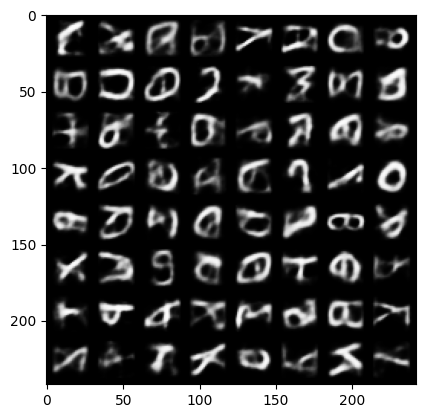

In [15]:
model_vae.eval()
x_hat = model_vae.sample(64, 'cpu')
show(make_grid(x_hat.view(64, 1, 28, 28).data.cpu()))

# Trực quan hóa không gian ẩn bằng UMAP

Với mỗi điểm dữ liệu trong MNIST, ta sẽ mã hóa nó thành một vector trong không gian ẩn 2 chiều. Sau đó, ta sẽ sử dụng UMAP để giảm chiều của các vector này xuống còn 2 chiều và trực quan hóa chúng trên biểu đồ.

Embedding batches:   0%|          | 0/163 [00:00<?, ?it/s]

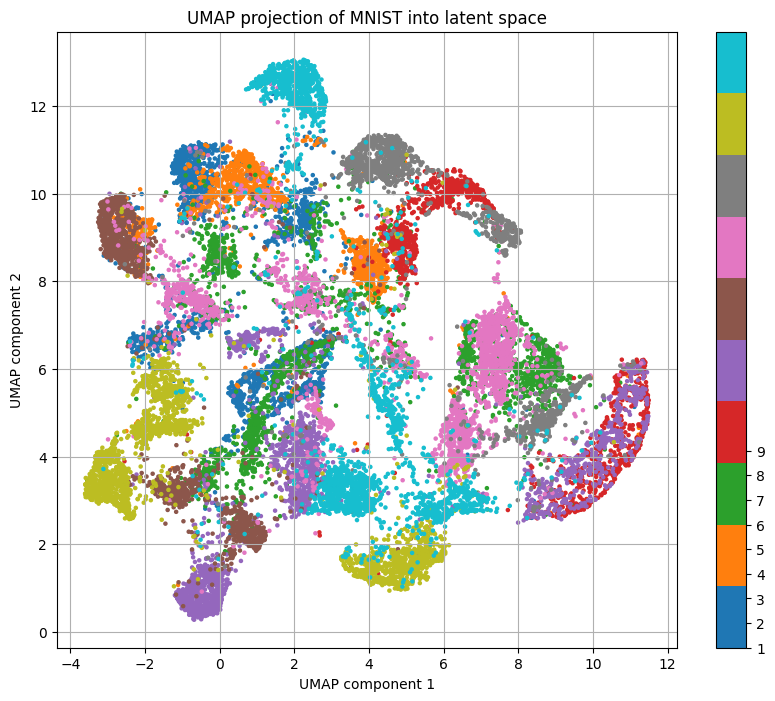

In [16]:
import umap
import warnings
warnings.filterwarnings('ignore')

all_zs = []
all_labels = []

model_vae.eval()
with torch.no_grad():
    for x_batch, y_batch in tqdm(test_loader, desc="Embedding batches"):
        x_batch = x_batch.to(device)
        x_batch = x_batch.view(x_batch.size(0), -1)
        z_mu, _ = model_vae.encoding(x_batch)
        all_zs.append(z_mu.cpu())
        all_labels.append(y_batch.cpu())

all_zs = torch.cat(all_zs, dim=0)
all_labels = torch.cat(all_labels, dim=0)

umap_model = umap.UMAP(n_components=2, n_neighbors=15, min_dist=0.1, random_state=42)
all_zs_2d = umap_model.fit_transform(all_zs.numpy())

plt.figure(figsize=(10, 8))
scatter = plt.scatter(all_zs_2d[:, 0], all_zs_2d[:, 1], c=all_labels, cmap='tab10', s=5)
plt.colorbar(scatter, ticks=range(10))
plt.title('UMAP projection of MNIST into latent space')
plt.xlabel('UMAP component 1')
plt.ylabel('UMAP component 2')
plt.grid(True)
plt.show()

In [17]:
# Lưu trọng số mô hình
torch.save(model_vae.state_dict(), 'vae_emnist_letters.pth')
print("Đã lưu trọng số mô hình tại 'vae_emnist_letters.pth'")

Đã lưu trọng số mô hình tại 'vae_emnist_letters.pth'
